# Ion-velocity 1

The goal of this notebook is to estimate the ion velocity by locating the position of the ion wavefront

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
colorlist = list(matplotlib.colors.TABLEAU_COLORS)
import simplesimdb as simplesim
from netCDF4 import Dataset
import feltorutilities as fp

from methods.SolutionClass2 import SolutionClass
from methods.make_input import make_plasma_input
from methods.save_load_data2 import save_data, load_data
from methods.wavefront import get_wavefront_datapoint

We initialize adiabatic electrons

In [3]:
p_list = []

params = make_plasma_input()
x_len = params["grid"]["x"][-1]-params["grid"]["x"][0]

params["grid"]["Nx"]= 800
params["output"]["maxout"] = 800
params["output"]["tend"] = 4e3
params["init"]["type"] = "soft-step"
params["init"]["x_a"] = -0.0
params["init"]["alpha"] = 0.001
params["init"]["n_l"] = 1
params["init"]["n_r"] = 0.2
params["init"]["t_l"] = 1
params["init"]["t_r"] = 0.2
params["timestepper"]["type"] = "ARK"
params["timestepper"]["tableau"]  = "ARK-4-2-3"
params["poisson"]["eps"]= 1e-12
params["poisson"]["type"] = "anderson"
params["poisson"]["damping"] = 1e-1
params["physical"]["type"] = "adiabatic"
params["physical"]["resistivity"] = 0.0

params["advection"] = {"type" : "staggered", "variant" : "slope-limiter-explicit"}
params["timestepper"]["rtol"] = 1e-5

#params["bc"]["density"] = "PER"
#params["bc"]["velocity"] = "PER"
#params["bc"]["pressure"] = "PER"
#params["bc"]["potential"] = "DIR"

We simulate this with varying temperature

In [4]:
if False:
    sols = []
    for temp in [0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0]:
        params["init"]["t_l"] = temp * 1
        params["init"]["t_r"] = temp * 0.2
        sols.append(SolutionClass(params))

Saving:

In [5]:
if False:  # Just in case
    for i, sol in enumerate(sols):
        savefile = "DATA/Ion-vel_data/set {}".format(i+1)
        print(savefile)
        save_data(sol, filename=savefile)

Loading:

In [2]:
sols = []
for i in range(8):
    savefile = "DATA/Ion-vel_data/set {}".format(i+1)
    sols.append(load_data(filename=savefile))

Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero
Error: No temperature fields found. Setting to zero


In [3]:
for sol in sols:
    print(sol.params["bc"])

{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}
{'density': 'NEU', 'velocity': 'NEU', 'pressure': 'NEU', 'potential': 'DIR_NEU'}


Animating:

In [7]:
if False:
    for i, sol in enumerate(sols):
        savefile = f"DATA/Ion-vel_data/anime {i+1}.mp4"
        print(savefile)
        sol.animate_all(filename=savefile)

Gets the sizes of the arrays

In [8]:
print("x.shape =", sols[0].data_full["x"].shape)
print("t.shape =", sols[0].data_full["t"].shape)
print("data.shape =", sols[0].data_full["ne"].shape)

print("Specific time:", len(sols[0].data_full["ne"][0,:]))
print("Specific position:", len(sols[0].data_full["ne"][:,0]))

x.shape = (800,)
t.shape = (801,)
data.shape = (801, 800)
Specific time: 800
Specific position: 801


We plot the wavefront position as a function of time

Temperature: 0.6	 Slope (velocity): 1.459	 Theoretical velocity: 1.549	 Relative error: -6.168%
0.5199999999999999
Temperature: 0.8	 Slope (velocity): 1.680	 Theoretical velocity: 1.789	 Relative error: -6.463%
0.6933333333333334
Temperature: 1	 Slope (velocity): 1.875	 Theoretical velocity: 2.000	 Relative error: -6.674%
0.8666666666666667
Temperature: 1.2	 Slope (velocity): 2.050	 Theoretical velocity: 2.191	 Relative error: -6.853%
1.0399999999999998
Temperature: 1.4	 Slope (velocity): 2.211	 Theoretical velocity: 2.366	 Relative error: -7.013%
1.2133333333333332
Temperature: 1.6	 Slope (velocity): 2.362	 Theoretical velocity: 2.530	 Relative error: -7.108%
1.3866666666666667
Temperature: 1.8	 Slope (velocity): 2.502	 Theoretical velocity: 2.683	 Relative error: -7.229%
1.5600000000000003
Temperature: 2.0	 Slope (velocity): 2.636	 Theoretical velocity: 2.828	 Relative error: -7.312%
1.7333333333333334


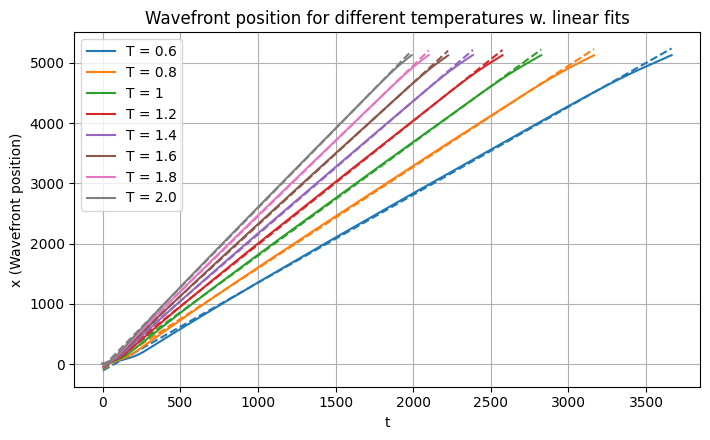

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8*0.9,5*0.9))

err_arr = []

for i, sol in enumerate(sols):
    c = colorlist[i]

    # Datapoints get
    data_ty = get_wavefront_datapoint(sol.data_full, data_key="ni", offset=0.3, direction="right", change="negative", interpolate=True)

    # Plot of data
    ax.plot(*data_ty, color=c, label="T = {}".format(sol.params["init"]["t_l"]))

    # Plot of fits
    nonan_t = [x for x in data_ty[0] if not np.isnan(x)]
    nonan_y = [x for x in data_ty[1] if not np.isnan(x)]

    fit_coeff = np.polyfit(nonan_t, nonan_y, deg=1)
    fit = lambda t: t*fit_coeff[0] + fit_coeff[1]
    t = np.linspace(min(nonan_t), max(nonan_t), 100)

    ax.plot(t, fit(t), '--', color=c)

    # Diagnostics
    slope = fit_coeff[0]
    v_theoretical = 2*np.sqrt(sol.params["init"]["t_l"])

    ni = sol.data_full["ni"][0]
    Ti = sol.data_full["Ti"][0]
    T_avg = np.trapz(ni*Ti) / np.trapz(ni)
    #v_theoretical = 2*np.sqrt(T_avg)
    rel_err = (slope-v_theoretical)/slope
    err_arr.append(rel_err)
                              
    print("Temperature: {0}\t Slope (velocity): {1:.3f}\t Theoretical velocity: {2:.3f}\t Relative error: {3:.3f}%"
          .format(sol.params["init"]["t_l"], 
                  slope, 
                  v_theoretical,
                  rel_err*100))
    print(T_avg)

ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("x (Wavefront position)")
ax.set_title("Wavefront position for different temperatures w. linear fits")
ax.grid(True)
fig.tight_layout()
plt.savefig("Wavefront position", dpi=400)

A quick investigation into how the error changes with temperature

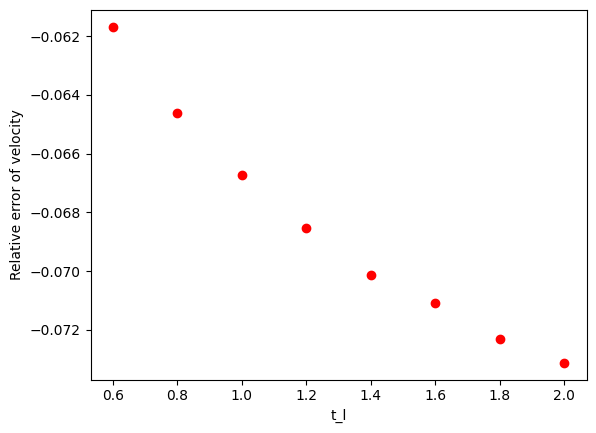

In [10]:
t_ls = []
for sol in sols:
    t_ls.append(sol.params["init"]["t_l"])

plt.plot(t_ls, err_arr, 'ro')
plt.xlabel("t_l")
plt.ylabel("Relative error of velocity")
plt.show()

This appears to be a square root relation which makes sense

___

# Plots for project

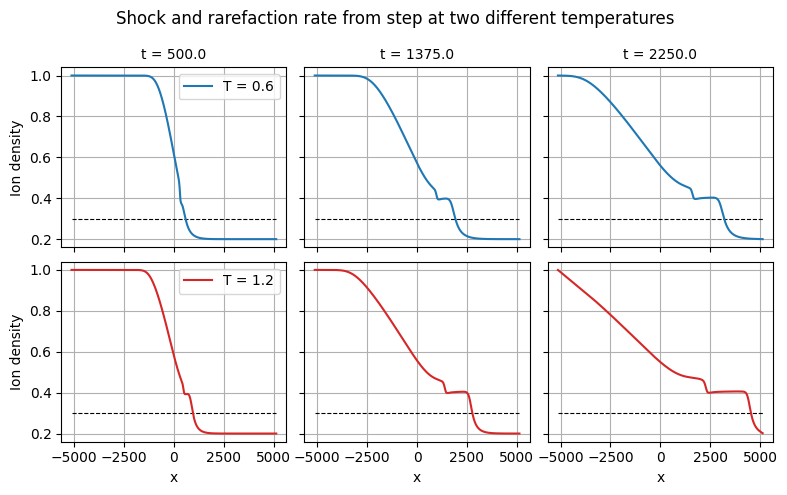

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(8,5), sharex=True, sharey=True)

t1 = 100
t2 = 275
t3 = 450

x    = sols[0].data_full["x"]
t    = sols[0].data_full["t"]
dat1 = sols[0].data_full["ni"]
dat2 = sols[3].data_full["ni"]
T1   = sols[0].params["init"]["t_l"]
T2   = sols[3].params["init"]["t_l"]

for ax in itertools.chain(*axes):
    ax.hlines(0.3, xmin=x[0], xmax=x[-1], linestyles='dashed', color='k', linewidth=0.8)

axes[0][0].plot(x, dat1[t1], label=f"T = {T1}", color = colorlist[0])
axes[0][1].plot(x, dat1[t2], label=f"T = {T1}", color = colorlist[0])
axes[0][2].plot(x, dat1[t3], label=f"T = {T1}", color = colorlist[0])

axes[1][0].plot(x, dat2[t1], label=f"T = {T2}", color = colorlist[3])
axes[1][1].plot(x, dat2[t2], label=f"T = {T2}", color = colorlist[3])
axes[1][2].plot(x, dat2[t3], label=f"T = {T2}", color = colorlist[3])


for ax, t in zip(axes[0], [t[t1], t[t2], t[t3]]):
    ax.grid(True)
    ax.set_title(f"t = {t}", fontsize = 10)

for ax in axes[1]:
    ax.grid(True)
    ax.set_xlabel("x")

axes[0][0].legend()
axes[0][0].set_ylabel("Ion density")
axes[1][0].legend()
axes[1][0].set_ylabel("Ion density")

fig.suptitle("Shock and rarefaction rate from step at two different temperatures")
fig.tight_layout()
fig.subplots_adjust(wspace = 0.08, hspace = 0.08)
plt.savefig("Wavefront temperature difference", dpi=400)
#plt.show()

In [12]:
for sol in sols:
    x  = sol.data_full["x"][0]
    t  = sol.data_full["t"][0]
    ni = sol.data_full["ni"][0]
    Ti = sol.data_full["Ti"][0]

    T_avg = np.trapz(ni*Ti) / np.trapz(ni)
    print(2*np.sqrt(T_avg))


1.4422205101855956
1.6653327995729061
1.8618986725025255
2.0396078054371136
2.2030282189144406
2.3551362310207593
2.4979991993593593
2.6331223544175333


### Changed plots

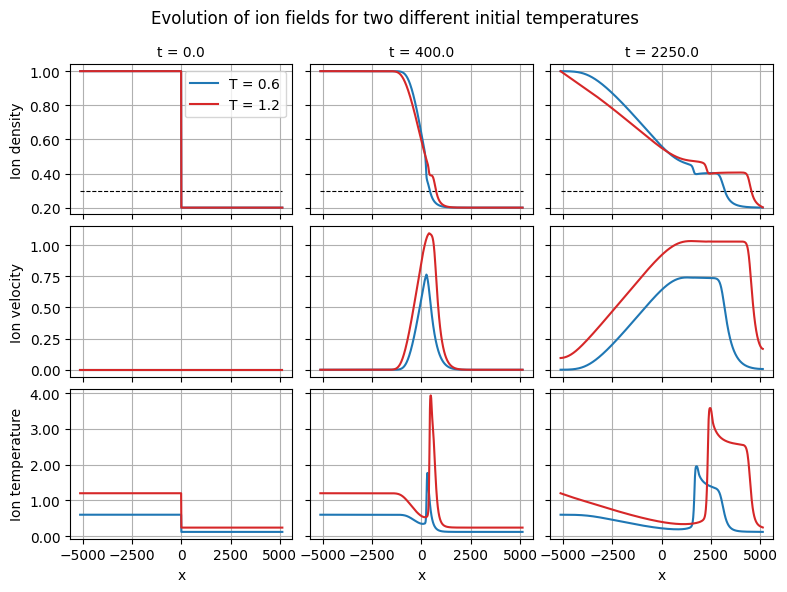

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(8,6), sharex=True, sharey='row')

t1 = 0
t2 = 80
t3 = 450

x    = sols[0].data_full["x"]
t    = sols[0].data_full["t"]
dat1 = sols[0].data_full
dat2 = sols[3].data_full
T1   = sols[0].params["init"]["t_l"]
T2   = sols[3].params["init"]["t_l"]

for ax in axes[0]:
    ax.hlines(0.3, xmin=x[0], xmax=x[-1], linestyles='dashed', color='k', linewidth=0.8)

for i, data_key in enumerate(["ni", "ui", "Ti"]):
    axes[i][0].plot(x, dat1[data_key][t1], label=f"T = {T1}", color = colorlist[0])
    axes[i][1].plot(x, dat1[data_key][t2], label=f"T = {T1}", color = colorlist[0])
    axes[i][2].plot(x, dat1[data_key][t3], label=f"T = {T1}", color = colorlist[0])

    axes[i][0].plot(x, dat2[data_key][t1], label=f"T = {T2}", color = colorlist[3])
    axes[i][1].plot(x, dat2[data_key][t2], label=f"T = {T2}", color = colorlist[3])
    axes[i][2].plot(x, dat2[data_key][t3], label=f"T = {T2}", color = colorlist[3])
    axes[i][0].yaxis.set_major_formatter('{x:.2f}')

    for ax in axes[i]:
        ax.grid(True)

for ax, t in zip(axes[0], [t[t1], t[t2], t[t3]]):
    ax.set_title(f"t = {t}", fontsize = 10)

for ax in axes[2]:
    ax.set_xlabel("x")

axes[0][0].legend()

axes[0][0].set_ylabel("Ion density")
axes[1][0].set_ylabel("Ion velocity")
axes[2][0].set_ylabel("Ion temperature")

fig.suptitle("Evolution of ion fields for two different initial temperatures")
fig.tight_layout()
fig.subplots_adjust(wspace = 0.08, hspace = 0.08)
plt.savefig("Ion fields step", dpi=400)
#plt.show()